In [ ]:
# langchain, openAI, neo4j
!pip install langchain==0.3.14
!pip install langchain_openai==0.3.0
!pip install neo4j==5.27.0
!pip install langchain-community==0.3.14

In [ ]:
from langchain_community.graphs import Neo4jGraph
import os
os.environ['OPENAI_API_KEY'] = "" # API 키를 입력하세요.

<ipython-input-3-5646b81df122>:6: LangChainDeprecationWarning: The class `Neo4jGraph` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jGraph``.
  graph = Neo4jGraph(url= "bolt://44.202.189.21:7687" , username="neo4j", password="figures-ability-miner")


Results structure: [{'nodes': [{'name': 'Answer', 'indexes': [], 'constraints': ["Constraint( id=19, name='constraint_7e29bbac', type='UNIQUENESS', schema=(:Answer {uuid}), ownedIndex=16 )"]}, {'name': 'Comment', 'indexes': [], 'constraints': ["Constraint( id=20, name='constraint_32ea8862', type='UNIQUENESS', schema=(:Comment {uuid}), ownedIndex=17 )"]}, {'name': 'User', 'indexes': [], 'constraints': ["Constraint( id=21, name='constraint_b13a3b7d', type='UNIQUENESS', schema=(:User {uuid}), ownedIndex=15 )"]}, {'name': 'Question', 'indexes': [], 'constraints': ["Constraint( id=18, name='constraint_401df8db', type='UNIQUENESS', schema=(:Question {uuid}), ownedIndex=13 )"]}, {'name': 'Tag', 'indexes': [], 'constraints': ["Constraint( id=22, name='constraint_64b1b1cf', type='UNIQUENESS', schema=(:Tag {name}), ownedIndex=14 )"]}], 'relationships': [({'name': 'Question', 'indexes': [], 'constraints': ["Constraint( id=18, name='constraint_401df8db', type='UNIQUENESS', schema=(:Question {uuid}

<ipython-input-3-5646b81df122>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


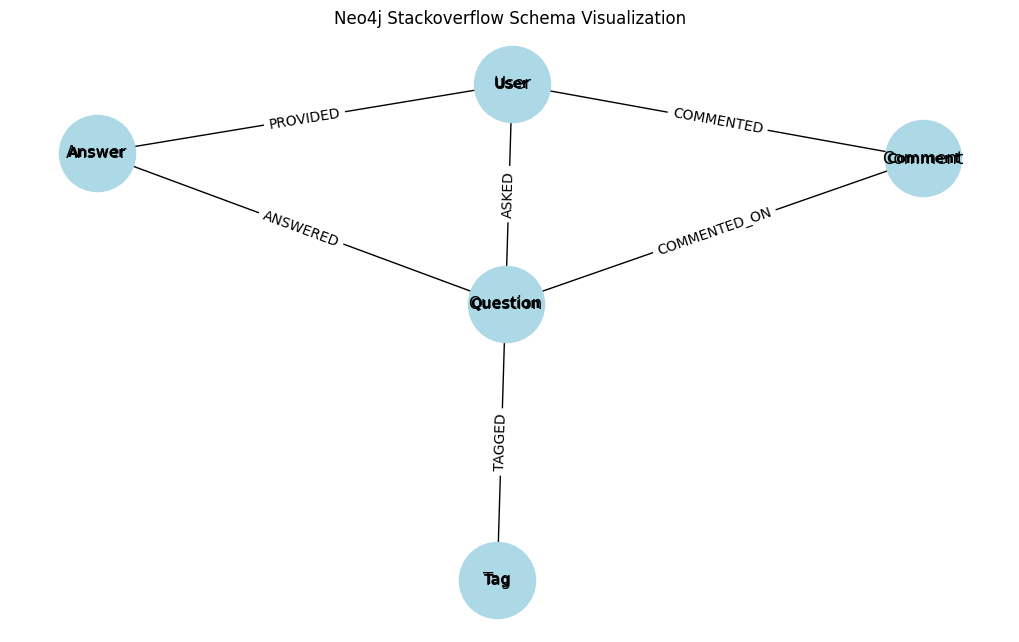

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Neo4jGraph 객체 사용
# neo4j Bolt URL, Username, Password를 입력하세요 #예시 
graph = Neo4jGraph(url= "bolt://44.202.189.21:7687" , username="neo4j", password="figures-ability-miner")

# 스키마 가져오기
query = """
CALL db.schema.visualization;
"""
results = graph.query(query)

# 결과 구조 확인
print("Results structure:", results)

# NetworkX 그래프 생성
G = nx.Graph()

# 결과가 리스트의 딕셔너리 형태로 반환됨
for result in results:
    # 노드 추가
    for node in result['nodes']:
        G.add_node(node['name'], name=node['name'])

    # 엣지 추가
    for rel in result['relationships']:
        start_node = rel[0]['name']
        end_node = rel[2]['name']
        rel_type = rel[1]
        G.add_edge(start_node, end_node, name=rel_type)

# 그래프 레이아웃 설정
pos = nx.spring_layout(G)

# 그래프 그리기
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold')

# 엣지 레이블 추가
edge_labels = nx.get_edge_attributes(G, 'name')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# 노드 레이블 추가
node_labels = nx.get_node_attributes(G, 'name')
nx.draw_networkx_labels(G, pos, node_labels, font_size=12)

plt.title("Neo4j Stackoverflow Schema Visualization")
plt.axis('off')
plt.tight_layout()
plt.show()


# 예제 4.8

In [ ]:
from langchain.chains import GraphCypherQAChain
from langchain_openai import ChatOpenAI
from langchain_community.graphs import Neo4jGraph
import os
# os.environ['OPENAI_API_KEY'] = "" # API 키를 입력

chain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0), model="gpt-4o-mini", graph=graph, verbose=True, allow_dangerous_requests=True
)
chain.invoke("누가 가장 많이 답변을 달았어? 답변 횟수도 같이 알려줘.")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (u:User)-[:PROVIDED]->(a:Answer)
WITH u, COUNT(a) AS answerCount
RETURN u.display_name, answerCount
ORDER BY answerCount DESC
LIMIT 1;
Full Context:
[{'u.display_name': 'cybersam', 'answerCount': 211}]

> Finished chain.


{'query': '누가 가장 많이 답변을 달았어? 답변 횟수도 같이 알려줘.',
 'result': 'cybersam이(가) 211번의 답변을 작성했어.'}

# 예제 4.9

In [ ]:
chain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0.5, model="gpt-4"), # gpt-4 모델 설정
    graph=graph,
    verbose=True,
    return_intermediate_steps=True,
    allow_dangerous_requests=True
)

chain.invoke("유저간의 상호작용을 분석하여 서로의 질문에 가장 자주 답변한 사용자 쌍을 찾아줘. 그리고 그 둘의 질문과 답변의 평균 점수도 출력해줘")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (u1:User)-[:ASKED]->(q1:Question)<-[:ANSWERED]-(a1:Answer)<-[:PROVIDED]-(u2:User),
      (u2)-[:ASKED]->(q2:Question)<-[:ANSWERED]-(a2:Answer)<-[:PROVIDED]-(u1)
WITH u1, u2, avg(a1.score) AS avg_score1, avg(a2.score) AS avg_score2
RETURN u1.display_name AS user1, u2.display_name AS user2, (avg_score1 + avg_score2) / 2 AS avg_score
ORDER BY avg_score DESC
LIMIT 1;
Full Context:
[{'user1': 'Aviral Srivastava', 'user2': 'Aviral Srivastava', 'avg_score': 1.0}]

> Finished chain.


{'query': '유저간의 상호작용을 분석하여 서로의 질문에 가장 자주 답변한 사용자 쌍을 찾아줘. 그리고 그 둘의 질문과 답변의 평균 점수도 출력해줘',
 'result': 'Aviral Srivastava와 Aviral Srivastava가 서로의 질문에 가장 자주 답변했습니다. 그들의 질문과 답변의 평균 점수는 1.0입니다.',
 'intermediate_steps': [{'query': 'MATCH (u1:User)-[:ASKED]->(q1:Question)<-[:ANSWERED]-(a1:Answer)<-[:PROVIDED]-(u2:User),\n      (u2)-[:ASKED]->(q2:Question)<-[:ANSWERED]-(a2:Answer)<-[:PROVIDED]-(u1)\nWITH u1, u2, avg(a1.score) AS avg_score1, avg(a2.score) AS avg_score2\nRETURN u1.display_name AS user1, u2.display_name AS user2, (avg_score1 + avg_score2) / 2 AS avg_score\nORDER BY avg_score DESC\nLIMIT 1;'},
  {'context': [{'user1': 'Aviral Srivastava',
     'user2': 'Aviral Srivastava',
     'avg_score': 1.0}]}]}

# 예제 4.10

In [ ]:
result = chain.invoke("GraphRAG 단어가 포함된 질문을 남긴 유저는 누구야?")